## FNO: Learning diffusivity (m) to solution (u) map for the Poisson problem

In [12]:
import sys
import os

import torch
import numpy as np

src_path = "../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import field_plot_grid
from plot_loss import plot_loss

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessorFNO

sys.path.append(src_path + 'nn/fno/')
sys.path.append(src_path + 'uq/')
from torch_fno2d import FNO2D 
import uq_fno as uq
import uq_evaluation as uq_eval

import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import spearmanr
import conformal_predictor as cp

In [13]:
data_folder = '../../../autodl-tmp/data/'
results_dir = data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [14]:
num_train = 3500
num_test = 1000

num_Y_components = 1 # scalar field
out_coordinate_dimension = 2 # domain for output function is 2D

coarsen_grid_factor = 1 # select every coarsen_grid_factor-th point so that we can coarsen the grid

# training hyperparameters
batch_size = 20
epochs = 500
lr = 1.0e-3

data_prefix = 'Poisson'
data = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples_.npz', num_train, num_test, num_Y_components, coarsen_grid_factor)

train_data = {'X_train': data.X_train, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'Y_train': data.Y_test}

# get data to save
data_to_save = data.get_data_to_save()

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)

X_train: torch.Size([3500, 51, 51, 3])
Y_train: torch.Size([3500, 51, 51, 1])
X_test: torch.Size([1000, 51, 51, 3])
Y_test: torch.Size([1000, 51, 51, 1])


In [15]:
num_test_shift = 400
# Shifting data sets
data_type=[['no-ood',0.005,0.2,1,0],['ood-1',0.0005,0.2,1,0],['ood-2',0.001,0.2,1,0],\
           ['ood-3',0.01,0.2,1,0],['ood-4',0.05,0.2,1,0],['ood-5',0.1,0.2,1,0], \
            ['ood-6',0.5,0.2,1,0]]
data_shifting = []
data_shifting_data = []
for datatype in data_type:
    data_shifting.append(DataProcessorFNO(data_folder + data_prefix + f'_FNO_samples_{datatype[0]}.npz', 100, 400, num_Y_components, coarsen_grid_factor))
    data_shifting_data.append({'X_train': data_shifting[-1].X_test, 'Y_train': data_shifting[-1].Y_test})

## Create model and train the network

In [16]:
num_layers = 3
width = 20 # dimension of hidden output space
fourier_modes1 = 8
fourier_modes2 = 8

model_save_path = results_dir + 'FNO/'
model_save_file = model_save_path + 'model.pkl'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = FNO2D(num_layers, width, fourier_modes1, fourier_modes2, \
              num_Y_components, save_file = model_save_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Using device: cuda
Number of trainable parameters: 154961


In [17]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_Y_components': num_Y_components, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'coarsen_grid_factor': coarsen_grid_factor, \
                    'num_layers': num_layers, \
                    'width': width, \
                    'fourier_modes1': fourier_modes1, \
                    'fourier_modes2': fourier_modes2, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}

# attach it to the model
model.metadata = model_metadata


In [8]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 154961 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 4.134e-01, Test Loss (l2 squared): 2.270e-01, Time (sec): 1.300
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 6.671e-03, Test Loss (l2 squared): 7.106e-03, Time (sec): 1.629
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 4.737e-03, Test Loss (l2 squared): 4.579e-03, Time (sec): 1.178
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
----

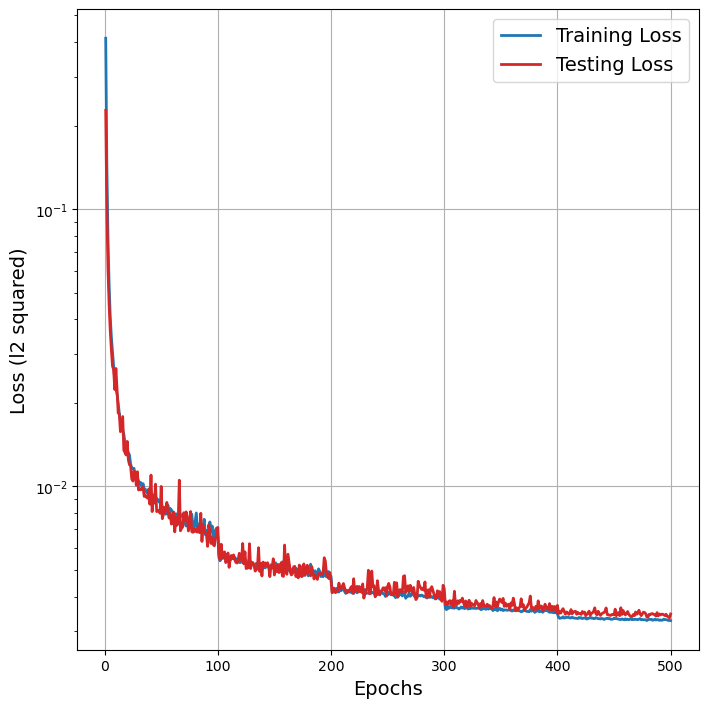

In [9]:
## Plotting the loss history

plot_loss( model.train_loss_log[:, 0], \
           model.test_loss_log[:, 0], \
           fs = 14, lw = 2, \
           savefile = results_dir+'loss_his.png', \
           figsize = [7,7])

## Test and plot the output of network

In [10]:
# load the model
model = torch.load(model_save_file, weights_only=False)

In [11]:
Y_test = test_data['Y_train'].detach().numpy()
Y_test_pred = model.predict(test_data['X_train']).detach().cpu().numpy()
print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))
a = Y_test.reshape(Y_test.shape[0], -1)
b = Y_test_pred.reshape(Y_test_pred.shape[0], -1)
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))
error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)
print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 51, 51, 1), test_pred shape: (1000, 51, 51, 1)
a shape: (1000, 2601), b shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 6.913e-02, Std Loss (rel l2): 2.183e-02


In [12]:
def apply_grid_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids[:, 0], bc_node_ids[:,1]] = bc_value
    return u

i_plot =   993, error (rel l2): 4.035e-03
i_plot =   859, error (rel l2): 6.803e-03
i_plot =   298, error (rel l2): 4.268e-03
i_plot =   553, error (rel l2): 6.493e-03


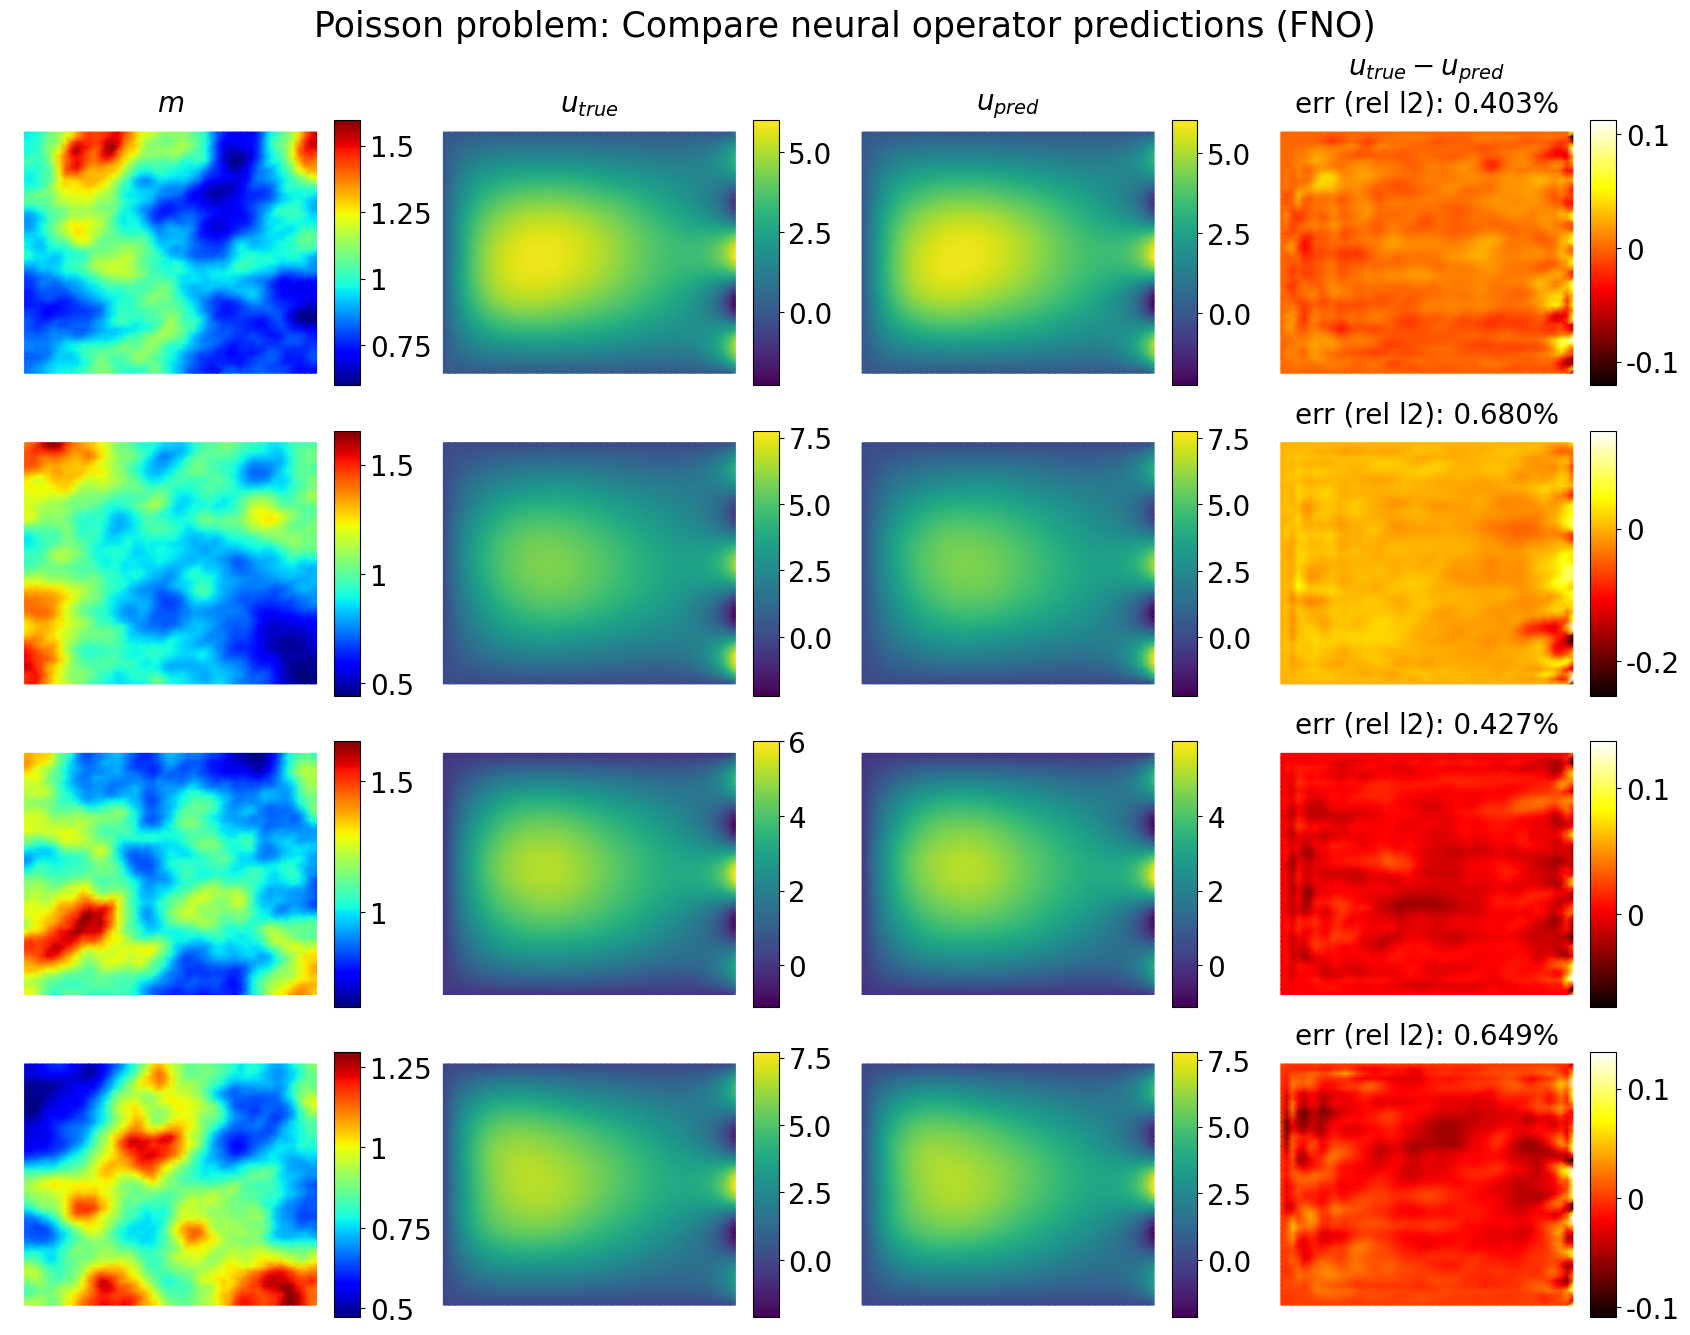

In [13]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(17, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

grid_x, grid_y = data.grid_x_test[0], data.grid_y_test[0]

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)[:, :, 0]
        i_truth = data.decoder_Y(i_truth)[:, :, 0]
        i_m_test = data.decoder_X(i_m_test)[:, :, 0]
    else:
        i_pred = i_pred[:, :, 0]
        i_truth = i_truth[:, :, 0]
        i_m_test = i_m_test[:, :, 0]
    if apply_dirichlet_bc_flag:
        i_pred = apply_grid_dirichlet_bc(i_pred, 0.0, data.u_grid_dirichlet_boundary_nodes)
        i_truth = apply_grid_dirichlet_bc(i_truth, 0.0, data.u_grid_dirichlet_boundary_nodes)
        # # verify for i_truth
        # a = i_truth[i, data.u_grid_dirichlet_boundary_nodes[:,0], data.u_grid_dirichlet_boundary_nodes[:,1]]
        # if np.abs(a).max() > 1.0e-9:
        #     print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(a.max()))
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff.flatten()) / np.linalg.norm(i_truth.flatten())
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot_grid(axs[i,j], uvec[j], grid_x, grid_y, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()

## Uncertainty Quantification Sampling

## HMC

In [54]:
hmc_num_samples = 10000        # Number of posterior samples to collect
hmc_burn_in = 9900            # Burn-in iterations
hmc_leapfrog_steps = 10       # Number of leapfrog steps per iteration
hmc_initial_step_size = 1e-5  # Initial leapfrog step size
train_num = 100               # Use part of training data for HMC to save time

model = torch.load(model_save_file, weights_only=False)
model.to(device)

real_meta = uq.real_param_metadata(model)
if not real_meta:
    raise ValueError("No real-valued trainable parameters found for HMC.")
hmc_prior_std = max(uq.pack_real_params(real_meta).std().item(), 1e-8)
hmc_noise_std = 0.2         # Observation noise std

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Prepare training data for log probability
X_train_tensor = train_data["X_train"].clone().detach().to(device)[:train_num]
Y_train_tensor = train_data["Y_train"].clone().detach().to(device)[:train_num]

# Run HMC (NUTS)
print("Running HMC sampling...")
hmc_samples = uq.hmc_nuts(
    model,
    X_train_tensor,
    Y_train_tensor,
    num_samples=hmc_num_samples,
    burn_in=hmc_burn_in,
    step_size=hmc_initial_step_size,
    num_steps_per_sample=hmc_leapfrog_steps,
    noise_std=hmc_noise_std,
    prior_std=hmc_prior_std
    )

torch.save(hmc_samples, model_save_path + 'hmc_samples.pt')

Running HMC sampling...
Running HMC (NUTS) on all real-valued layers using hamiltorch...
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  1.9662321903979318e-07 |  9896/10000 | 10.28       
0d:00:16:11 | 0d:00:00:00 | #################### | 10000/10000 | 10.30       
Acceptance Rate 0.79
Reconstructing full parameter samples (including complex weights held fixed)...


## SGLD

In [ ]:
# SGLD Sampling Parameters (better suited for mini-batch than HMC)
num_samples = 10000      # Number of posterior samples to collect
burn_in = 2000          # Burn-in iterations
step_size = 1e-7       # Initial step size for SGLD
step_decay = 0.9995    # Step size decay per iteration
min_step_size = 1e-9   # Minimum step size
noise_std = 0.2        # Observation noise std
sgld_batch_size = 100  # Mini-batch size for memory efficiency
slices = 100 

model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Keep a copy of the full model state for reconstruction
base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
real_meta = uq.real_param_metadata(model)
if not real_meta:
    raise ValueError("No real-valued trainable parameters found for SGLD.")
real_size = sum(item["numel"] for item in real_meta)
prior_std = max(uq.pack_real_params(real_meta).std().item(), 1e-8)
print(f"Real trainable params (sampled): {real_size}, prior_std (real-only): {prior_std:.3e}")

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Prepare training data for log probability
X_train_tensor = train_data["X_train"].clone().to(device)
Y_train_tensor = train_data["Y_train"].clone().to(device)

log_prob_fn = uq.make_log_prob_fn(
    model, X_train_tensor, Y_train_tensor,
    prior_std=prior_std,
    noise_std=noise_std,
    batch_size=sgld_batch_size,
    reduce_output_mean=True,
    real_params_only=True,
    real_meta=real_meta,
    )

flat0 = uq.pack_real_params(real_meta).detach().requires_grad_(True)
print(f"Initial real parameter vector shape: {flat0.shape}")

# Run SGLD (Stochastic Gradient Langevin Dynamics)
print("Running SGLD sampling...")
sgld_samples, final_step_size = uq.sgld(
    log_prob_fn,
    flat0,
    step_size=step_size,
    num_samples=num_samples,
    burn_in=burn_in,
    step_decay=step_decay,
    min_step_size=min_step_size
    )

sgld_samples = sgld_samples[::slices]
print(f"SGLD completed. Final step size: {final_step_size:.2e}")
print(f"Number of samples collected: {len(sgld_samples)}")

def build_full_vector_sgld(trainable_flat):
    return uq.build_full_vector_from_real_sample(model, real_meta, trainable_flat, base_state)

sgld_samples_full = torch.stack([build_full_vector_sgld(s.detach()) for s in sgld_samples])
torch.save(sgld_samples_full, model_save_path + 'sgld_samples.pt')

SGLD restricted to last layer. Trainable params: 154961
Real trainable params (sampled): 1361, prior_std (real-only): 2.581e-01
Initial real parameter vector shape: torch.Size([1361])
Running SGLD sampling...
Starting SGLD sampling...
  Burn-in: 2000, Samples: 10000
  Initial step size: 1.00e-07
Iter  100/12000: step_size = 9.51e-08, phase = burn-in
Iter  200/12000: step_size = 9.05e-08, phase = burn-in
Iter  300/12000: step_size = 8.61e-08, phase = burn-in
Iter  400/12000: step_size = 8.19e-08, phase = burn-in
Iter  500/12000: step_size = 7.79e-08, phase = burn-in
Iter  600/12000: step_size = 7.41e-08, phase = burn-in
Iter  700/12000: step_size = 7.05e-08, phase = burn-in
Iter  800/12000: step_size = 6.70e-08, phase = burn-in
Iter  900/12000: step_size = 6.38e-08, phase = burn-in
Iter 1000/12000: step_size = 6.06e-08, phase = burn-in
Iter 1100/12000: step_size = 5.77e-08, phase = burn-in
Iter 1200/12000: step_size = 5.49e-08, phase = burn-in
Iter 1300/12000: step_size = 5.22e-08, phas

## Monte-Carlo Dropout 


In [16]:
# It suffices to sample when evaluating.

## Laplace Approximation

In [21]:
noise_std = 0.2        
epoch_la = 50     

print("Computing diagonal Hessian...")
model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Keep a copy of the full model state for reconstruction
base_state = {k: v.detach().clone() for k, v in model.state_dict().items()}

real_meta = uq.real_param_metadata(model)
if not real_meta:
    raise ValueError("No real-valued trainable parameters found for Laplace.")
real_size = sum(item["numel"] for item in real_meta)
prior_std = max(uq.pack_real_params(real_meta).std().item(), 1e-8)
print(f"Real trainable params: {real_size}, prior_std (real-only): {prior_std:.3e}")

# Use a subset of training data for Hessian computation (for efficiency)
X_train_tensor = train_data["X_train"].clone().to(device)
Y_train_tensor = train_data["Y_train"].clone().to(device)
n_hessian = min(500, num_train)
hessian_idx = np.random.choice(num_train, n_hessian, replace=False)
X_hessian = X_train_tensor[hessian_idx]
Y_hessian = Y_train_tensor[hessian_idx]

# Compute diagonal Hessian over real parameters only
diag_hessian = uq.compute_diagonal_hessian(
    model, X_hessian, Y_hessian,
    noise_std=noise_std,
    prior_std=prior_std,
    device=device,
    batch_size=20, # Reduced batch size for FNO memory
    sample_points_per_batch=50,
    real_params_only=True,
    real_meta=real_meta
    )

# Compute posterior precision and variance (diagonal approximation)
posterior_precision = diag_hessian  # Already includes prior term
posterior_variance = 1.0 / (posterior_precision + 1e-10)

print(f"Number of real trainable parameters: {len(diag_hessian)}")
print(f"Mean posterior variance: {posterior_variance.mean().item():.7e}")
print(f"Max posterior variance: {posterior_variance.max().item():.7e}")

print("Sampling from Laplace posterior (real parameters only)...")

# Get MAP parameters (flattened active parameter vector)
map_params = uq.pack_real_params(real_meta).to(device)  # only packs requires_grad=True real params
posterior_std = torch.sqrt(posterior_variance)

la_samples = []
for i in range(epoch_la):
    noise = torch.randn_like(map_params) * posterior_std
    sampled_params = map_params + noise
    la_samples.append(sampled_params.detach().cpu())

# Reconstruct full parameter vectors (including fixed complex parameters)
print("Reconstructing full parameter vectors...")
def build_full_vector_la(real_flat):
    return uq.build_full_vector_from_real_sample(model, real_meta, real_flat, base_state)

la_samples_full = torch.stack([build_full_vector_la(s) for s in la_samples])

torch.save(la_samples_full, model_save_path + 'la_samples.pt')
print(f"Saved {len(la_samples_full)} full parameter samples (vector length {la_samples_full[0].numel()}).")

Computing diagonal Hessian...
Real trainable params: 1361, prior_std (real-only): 2.581e-01
  Processed 100/500 samples
  Processed 200/500 samples
  Processed 300/500 samples
  Processed 400/500 samples
  Processed 500/500 samples
Number of real trainable parameters: 1361
Mean posterior variance: 1.2558009e-03
Max posterior variance: 6.4577691e-02
Sampling from Laplace posterior (real parameters only)...
Reconstructing full parameter vectors...
Saved 50 full parameter samples (vector length 308561).


## Ensemble Learning

In [19]:
models = []
model_num = 10
model_save_paths = [model_save_path + f'model_{i+1}.pkl' for i in range(model_num)]

In [ ]:
for i in range(model_num):
    torch.manual_seed(1000*(i+1))
    model_save_files = model_save_paths[i]
    model_new = FNO2D(num_layers, width, fourier_modes1, fourier_modes2, \
              num_Y_components, save_file = model_save_file)
    model_new = model.to(device)
    model_new.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)
    torch.save(model_new, model_save_files)
    models.append(model_new)

## Evaluation metrics

In [55]:
results_id = []
results_shifting = []
std_id = []
std_shifting = []

In [56]:
hmc_samples = torch.load(model_save_path + 'hmc_samples.pt').to(device)
std_hmc = []
results_hmc = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_hmc.append(std_i)
        results_hmc.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_hmc))
results_shifting.append(np.stack(results_hmc))
del hmc_samples

 Complete 1 epoch
 Complete 2 epoch
 Complete 3 epoch
 Complete 4 epoch
 Complete 5 epoch
 Complete 6 epoch
 Complete 7 epoch
 Complete 8 epoch


In [57]:
sgld_samples = torch.load(model_save_path + 'sgld_samples.pt').to(device)
std_sgld = []
results_sgld = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'sgld', sgld_samples=sgld_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'sgld', sgld_samples=sgld_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_sgld.append(std_i)
        results_sgld.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_sgld))
results_shifting.append(np.stack(results_sgld))
del sgld_samples

 Complete 1 epoch
 Complete 2 epoch
 Complete 3 epoch
 Complete 4 epoch
 Complete 5 epoch
 Complete 6 epoch
 Complete 7 epoch
 Complete 8 epoch


In [58]:
std_mcd = []
results_mcd = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    uq.inject_dropout(model)
    torch.nn.Module.train(model)
    for module in model.modules():
        if isinstance(module, (torch.nn.Dropout, torch.nn.Dropout2d)):
            torch.nn.Module.train(module)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'mcd')
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'mcd')
        std_mcd.append(std_i)
        results_mcd.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_mcd))
results_shifting.append(np.stack(results_mcd))


Running MC Dropout sampling...
 Complete 1 epoch
Running MC Dropout sampling...
 Complete 2 epoch
Running MC Dropout sampling...
 Complete 3 epoch
Running MC Dropout sampling...
 Complete 4 epoch
Running MC Dropout sampling...
 Complete 5 epoch
Running MC Dropout sampling...
 Complete 6 epoch
Running MC Dropout sampling...
 Complete 7 epoch
Running MC Dropout sampling...
 Complete 8 epoch


In [59]:
la_samples = torch.load(model_save_path + 'la_samples.pt').to(device)
std_la = []
results_la = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'la', la_samples=la_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'la', la_samples=la_samples.clone()) # pyright: ignore[reportAttributeAccessIssue]
        std_la.append(std_i)
        results_la.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_la))
results_shifting.append(np.stack(results_la))
del la_samples

 Complete 1 epoch
 Complete 2 epoch
 Complete 3 epoch
 Complete 4 epoch
 Complete 5 epoch
 Complete 6 epoch
 Complete 7 epoch
 Complete 8 epoch


In [60]:
std_de = []
results_de = []
for i in range(-1,7):
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, None, 'de', model_ensemble=model_save_paths)  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], None, 'de', model_ensemble=model_save_paths) # pyright: ignore[reportAttributeAccessIssue]
        std_de.append(std_i)
        results_de.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_de))
results_shifting.append(np.stack(results_de))

Computing Deep Ensemble predictions...
 Complete 1 epoch
Computing Deep Ensemble predictions...
 Complete 2 epoch
Computing Deep Ensemble predictions...
 Complete 3 epoch
Computing Deep Ensemble predictions...
 Complete 4 epoch
Computing Deep Ensemble predictions...
 Complete 5 epoch
Computing Deep Ensemble predictions...
 Complete 6 epoch
Computing Deep Ensemble predictions...
 Complete 7 epoch
Computing Deep Ensemble predictions...
 Complete 8 epoch


In [61]:
# Save UQ results
results_id = np.array(results_id) # method*metric
results_shifting = np.array(results_shifting) # method*datatype*metric
std_id = np.array(std_id) # method*sample
std_shifting = np.array(std_shifting) # method*datatype*sample
np.savez(model_save_path + 'uq_results_fno.npz', results_id=results_id, results_shifting=results_shifting, std_id=std_id, std_shifting=std_shifting)

## Assess evaluation metrics

In [62]:
# load data if needed
results_id, results_shifting, std_id, std_shifting = np.load(model_save_path + 'uq_results_fno.npz').values()

### ID data performance

In [63]:
method = ['HMC', 'SGLD', 'MC Dropout', 'Laplace Approximation', 'Ensemble', ]
uq_eval.comparison_uq(results_id, method)


Metric                             HMC         SGLD   MC Dropout Laplace Approximation   Ensemble
-------------------------------------------------------------------------------------
RMSE                            3.8775       3.1634       0.3639       0.0643     0.0499
Coverage 1σ (%)                   3.44         5.50       100.00        99.95      99.33
Coverage 2σ (%)                   6.88        11.02       100.00       100.00      99.91
Coverage 3σ (%)                  10.33        16.60       100.00       100.00      99.98
MPIW                            0.8000       0.9839       8.6365       1.3420     0.8049
NLL                           187.2464      72.0582       1.6354      -0.2204    -0.6551


### Shifting data performance

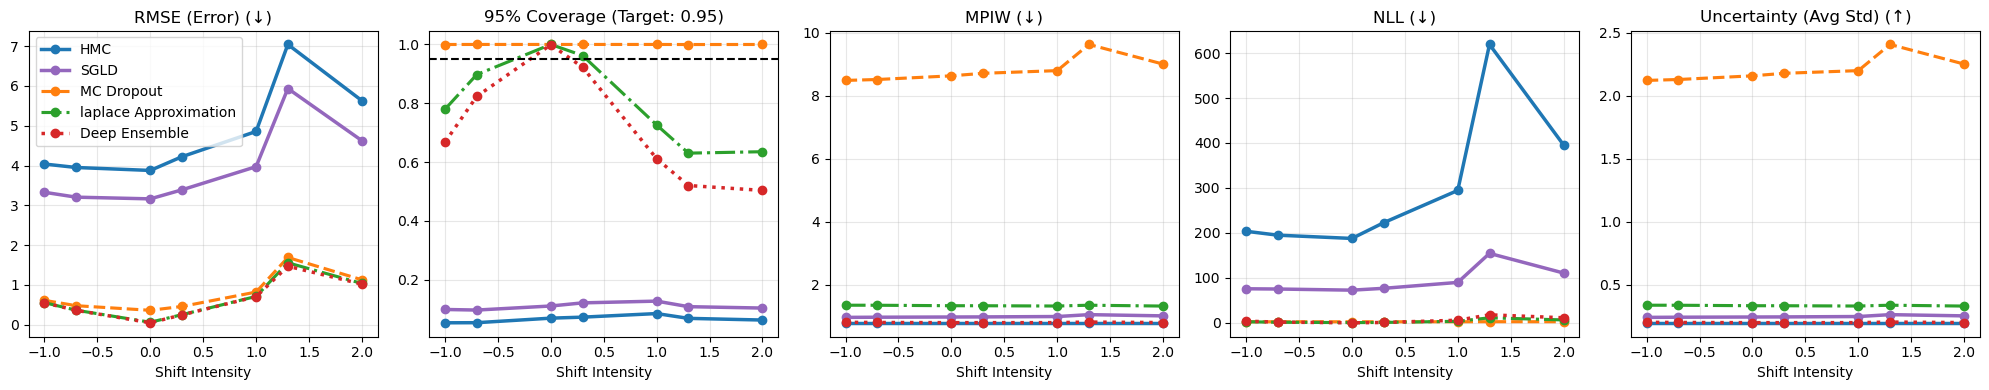

In [64]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
levels = [-1, -0.7, 0, 0.3, 1, 1.3, 2]
results_shifting_copy = results_shifting.copy()
results_shifting_copy[:,0,:] = results_id
results_shifting_copy[:,[2,0,1],:] = results_shifting_copy[:,[0,1,2],:]
uq_eval.run_regression_shift(method, levels, results_shifting_copy)

### Robustness check

In [65]:
uq_eval.comparison_uq(results_shifting[:,0,:], method)


Metric                             HMC         SGLD   MC Dropout laplace Approximation Deep Ensemble
-------------------------------------------------------------------------------------
RMSE                            3.9639       3.1814       0.3743       0.0798     0.0670
Coverage 1σ (%)                   3.30         5.60       100.00        99.81      98.59
Coverage 2σ (%)                   6.57        11.22       100.00        99.99      99.85
Coverage 3σ (%)                   9.94        16.82       100.00       100.00      99.97
MPIW                            0.8000       0.9812       8.5891       1.3446     0.8053
NLL                           195.7170      72.2407       1.6284      -0.2067    -0.6304


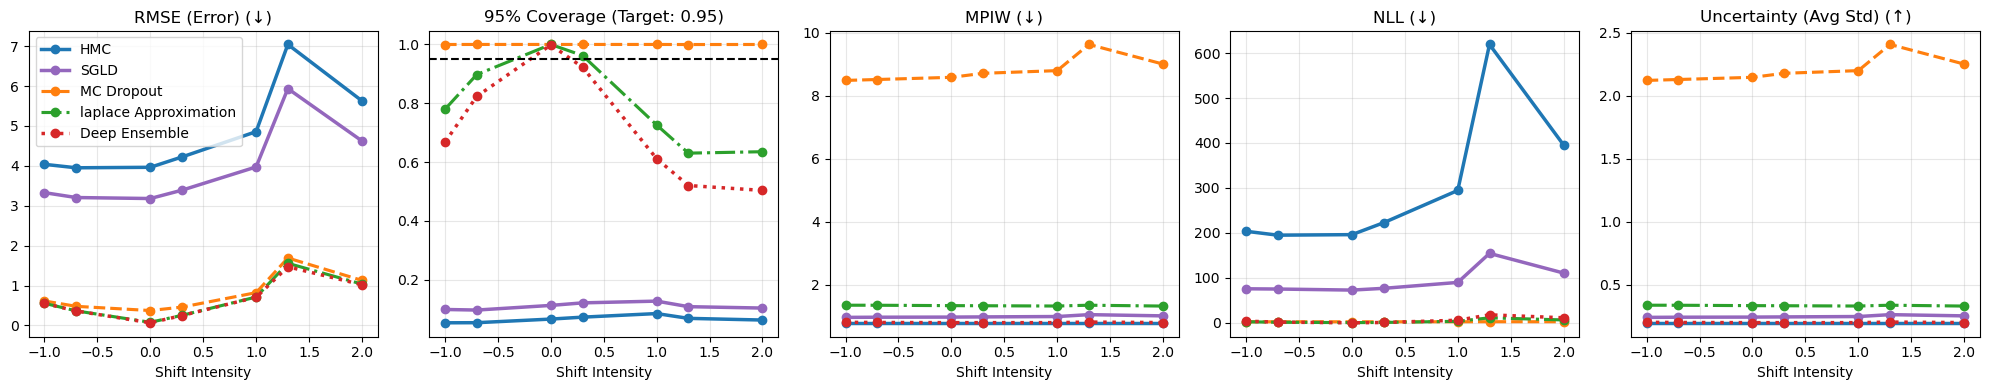

In [66]:
method = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
levels = [-1, -0.7, 0, 0.3, 1, 1.3, 2]
results_shifting_copy = results_shifting.copy()
results_shifting_copy[:,[2,0,1],:] = results_shifting_copy[:,[0,1,2],:]
uq_eval.run_regression_shift(method, levels, results_shifting_copy)

## OOD data detection

Method: HMC, Data: 0.005 -> AUROC: 0.5316
Method: HMC, Data: 0.0005 -> AUROC: 0.9747
Method: HMC, Data: 0.001 -> AUROC: 0.8975
Method: HMC, Data: 0.01 -> AUROC: 0.3263
Method: HMC, Data: 0.05 -> AUROC: 0.1077
Method: HMC, Data: 0.1 -> AUROC: 0.1240
Method: HMC, Data: 0.5 -> AUROC: 0.0389
Method: SGLD, Data: 0.005 -> AUROC: 0.5147
Method: SGLD, Data: 0.0005 -> AUROC: 0.9354
Method: SGLD, Data: 0.001 -> AUROC: 0.7772
Method: SGLD, Data: 0.01 -> AUROC: 0.4423
Method: SGLD, Data: 0.05 -> AUROC: 0.2639
Method: SGLD, Data: 0.1 -> AUROC: 0.3170
Method: SGLD, Data: 0.5 -> AUROC: 0.2048
Method: MC Dropout, Data: 0.005 -> AUROC: 0.5039
Method: MC Dropout, Data: 0.0005 -> AUROC: 0.5658
Method: MC Dropout, Data: 0.001 -> AUROC: 0.5549
Method: MC Dropout, Data: 0.01 -> AUROC: 0.5222
Method: MC Dropout, Data: 0.05 -> AUROC: 0.5036
Method: MC Dropout, Data: 0.1 -> AUROC: 0.5563
Method: MC Dropout, Data: 0.5 -> AUROC: 0.5122
Method: laplace Approximation, Data: 0.005 -> AUROC: 0.4945
Method: laplace A

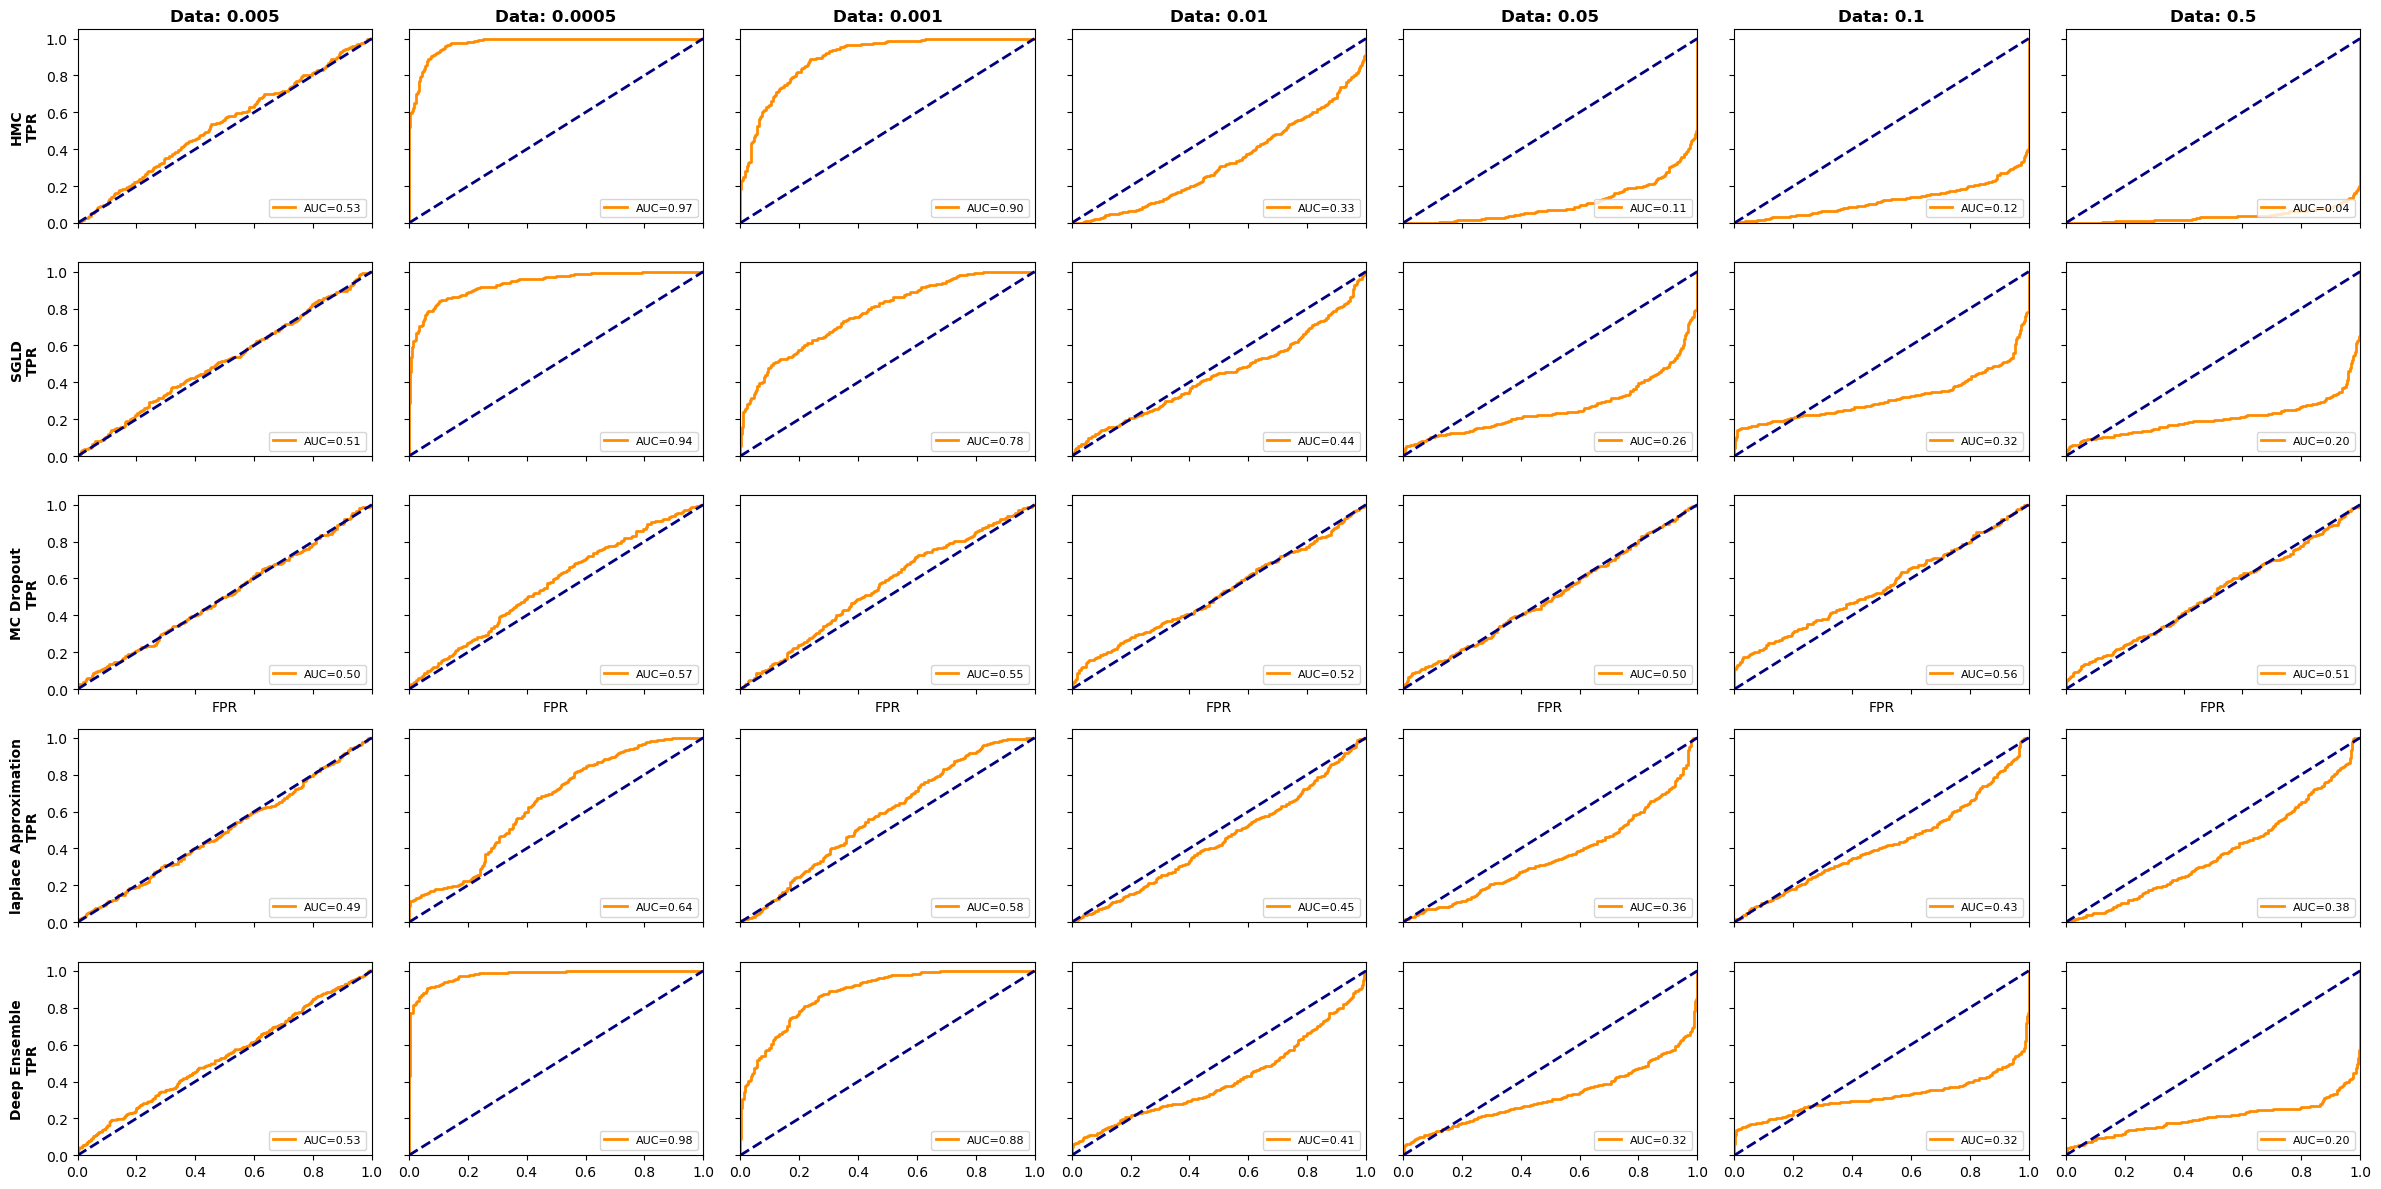

In [67]:
uq_methods_list = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
datatypes = [0.005, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(24, 12), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes):
        ax = axes[i, j]
        ood = np.concatenate((std_id[i], std_shifting[i][j]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_id[i].shape[0]), np.ones(std_shifting[i][j].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

Method: HMC, Data: 0.0005 -> AUROC: 0.9715
Method: HMC, Data: 0.001 -> AUROC: 0.8842
Method: HMC, Data: 0.01 -> AUROC: 0.2984
Method: HMC, Data: 0.05 -> AUROC: 0.0967
Method: HMC, Data: 0.1 -> AUROC: 0.1142
Method: HMC, Data: 0.5 -> AUROC: 0.0350
Method: SGLD, Data: 0.0005 -> AUROC: 0.9288
Method: SGLD, Data: 0.001 -> AUROC: 0.7638
Method: SGLD, Data: 0.01 -> AUROC: 0.4282
Method: SGLD, Data: 0.05 -> AUROC: 0.2551
Method: SGLD, Data: 0.1 -> AUROC: 0.3089
Method: SGLD, Data: 0.5 -> AUROC: 0.1971
Method: MC Dropout, Data: 0.0005 -> AUROC: 0.5604
Method: MC Dropout, Data: 0.001 -> AUROC: 0.5504
Method: MC Dropout, Data: 0.01 -> AUROC: 0.5161
Method: MC Dropout, Data: 0.05 -> AUROC: 0.4993
Method: MC Dropout, Data: 0.1 -> AUROC: 0.5518
Method: MC Dropout, Data: 0.5 -> AUROC: 0.5072
Method: laplace Approximation, Data: 0.0005 -> AUROC: 0.6473
Method: laplace Approximation, Data: 0.001 -> AUROC: 0.5859
Method: laplace Approximation, Data: 0.01 -> AUROC: 0.4502
Method: laplace Approximation, 

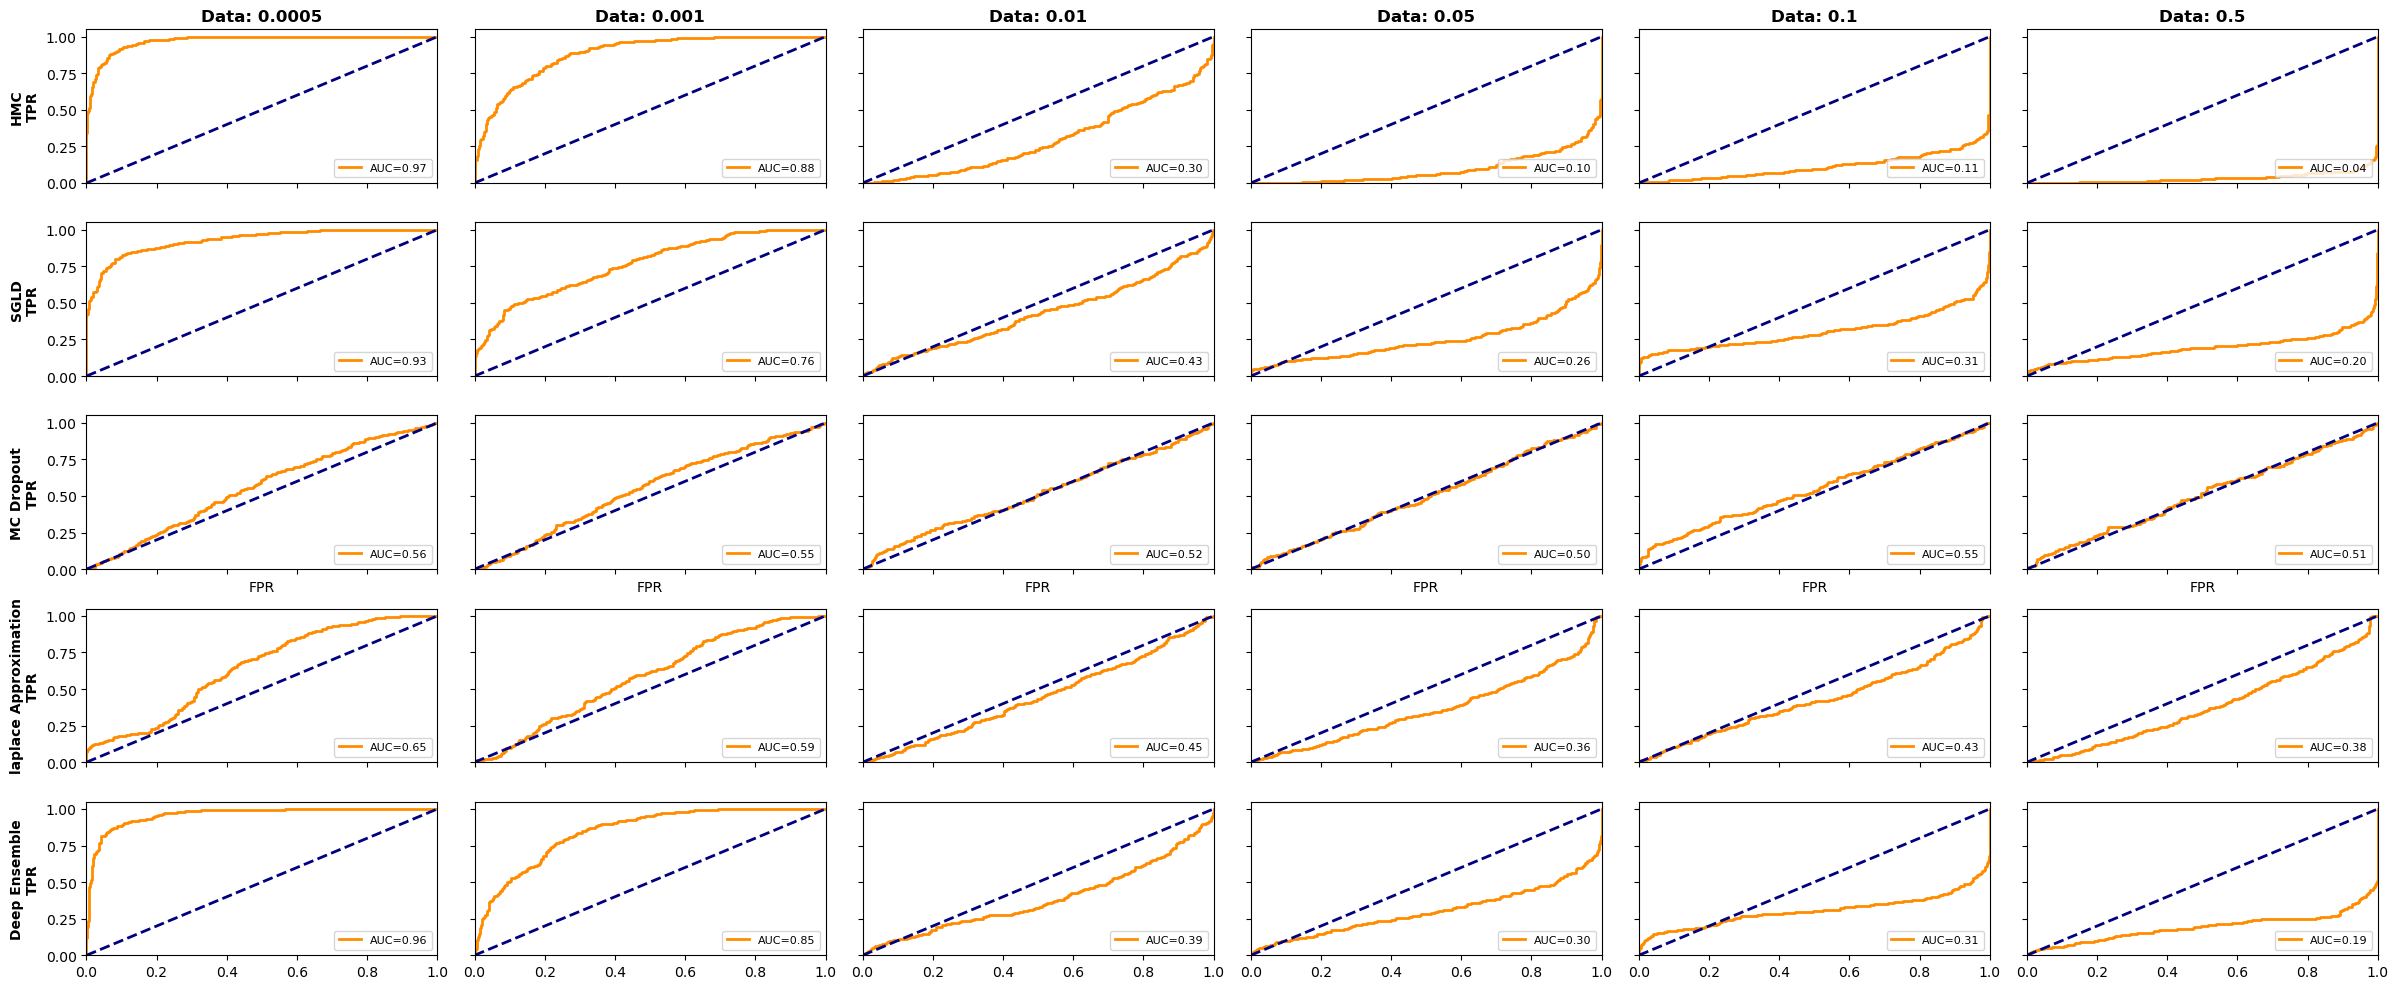

In [68]:
# If robustness check fails, compare between new samples.
uq_methods_list = ['HMC', 'SGLD', 'MC Dropout', 'laplace Approximation', 'Deep Ensemble']
datatypes = [0.005, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(24, 10), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes[1:]): # Skip index 0 (no-ood) to match ncols=6
        ax = axes[i, j]
        ood = np.concatenate((std_shifting[i][0], std_shifting[i][j+1]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_shifting[i][0].shape[0]), np.ones(std_shifting[i][j+1].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Conformalized Bayesian

Datatype        | ID Cov     | OOD Cov    | ID Width   | OOD Width  | AUROC   
-------------------------------------------------------------------------------------
0.005           | 92.8%      | 84.5%      | 0.8899     | 0.9323      | 0.5622
0.0005          | 92.8%      | 0.0%      | 0.8899     | 1.5035      | 0.9822
0.001           | 92.8%      | 0.0%      | 0.8899     | 1.2912      | 0.9001
0.01            | 92.8%      | 6.5%      | 0.8899     | 0.8532      | 0.4338
0.05            | 92.8%      | 0.2%      | 0.8899     | 0.8374      | 0.3391
0.1             | 92.8%      | 0.0%      | 0.8899     | 1.2470      | 0.3305
0.5             | 92.8%      | 0.5%      | 0.8899     | 0.8573      | 0.2143


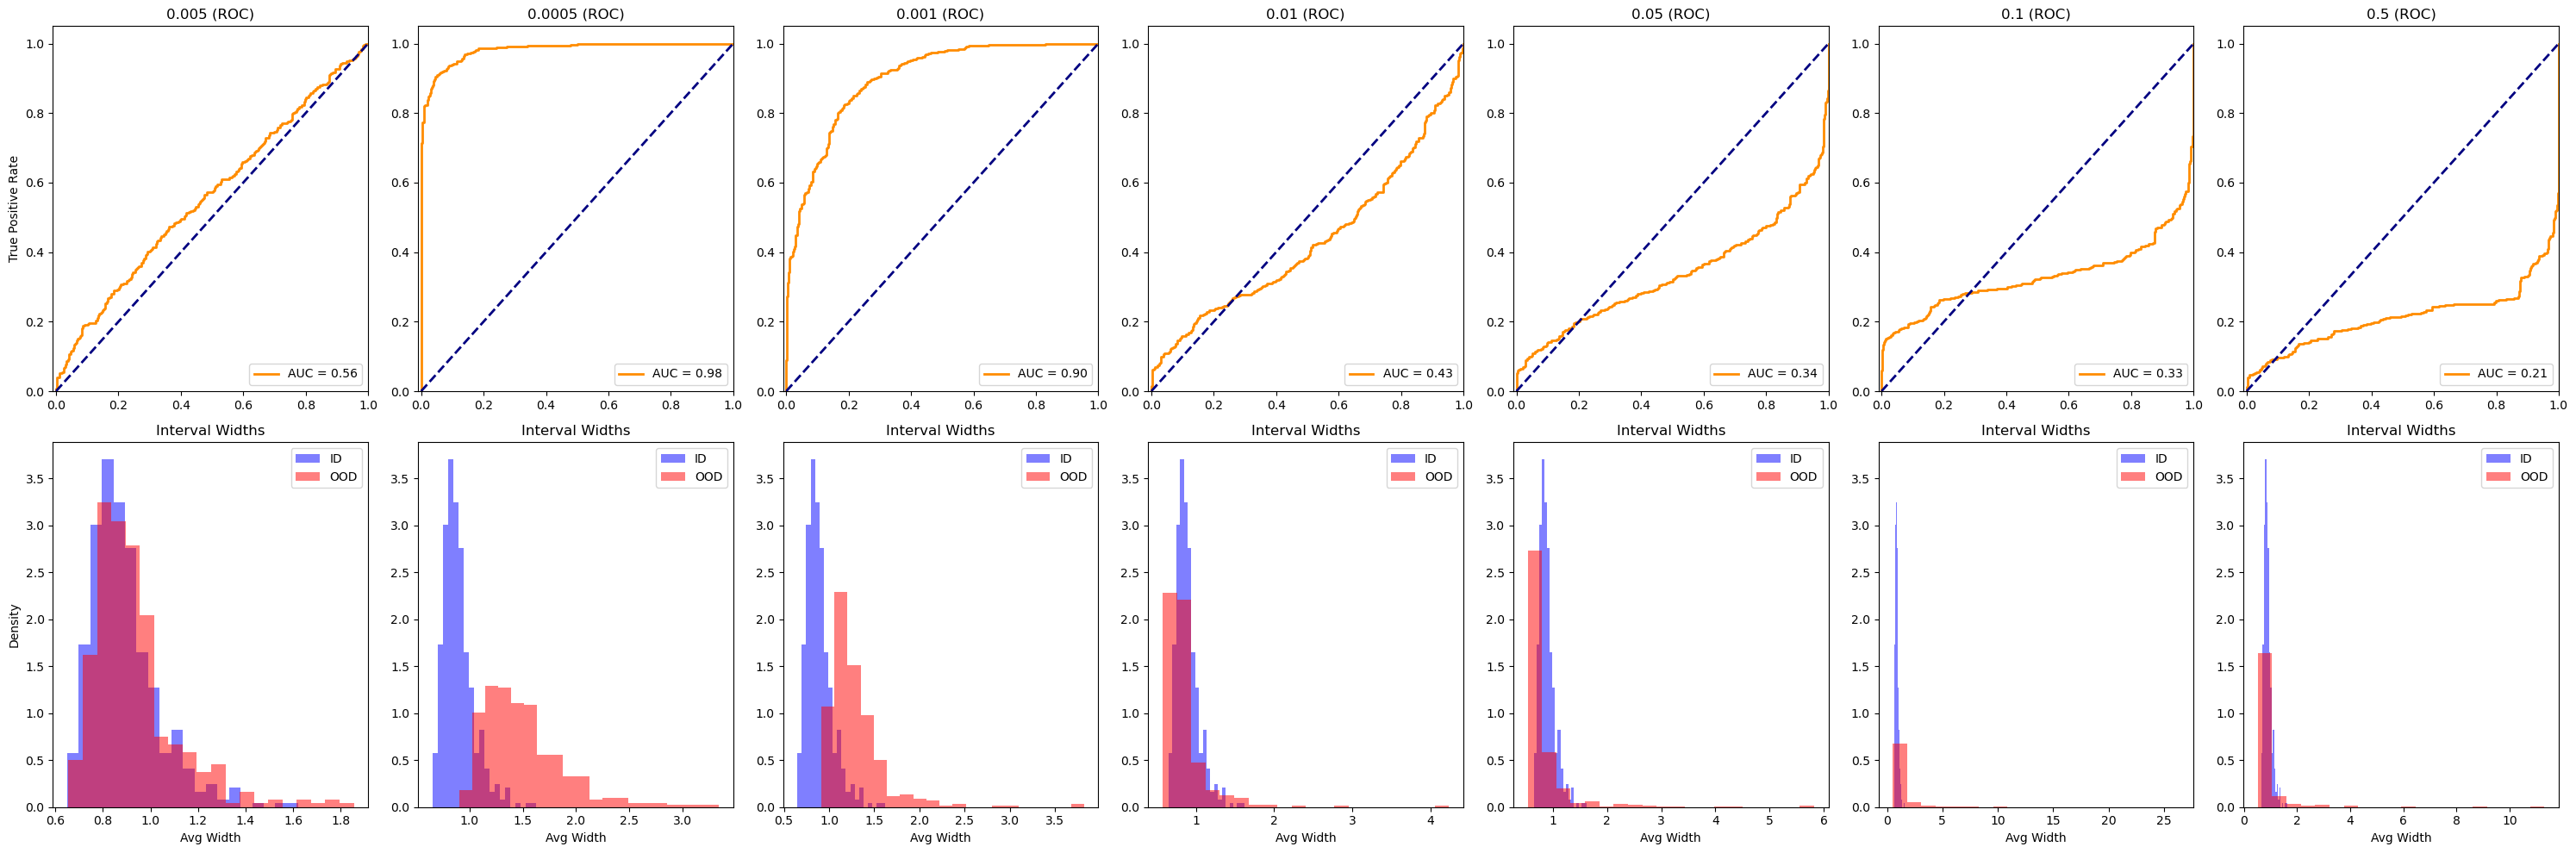

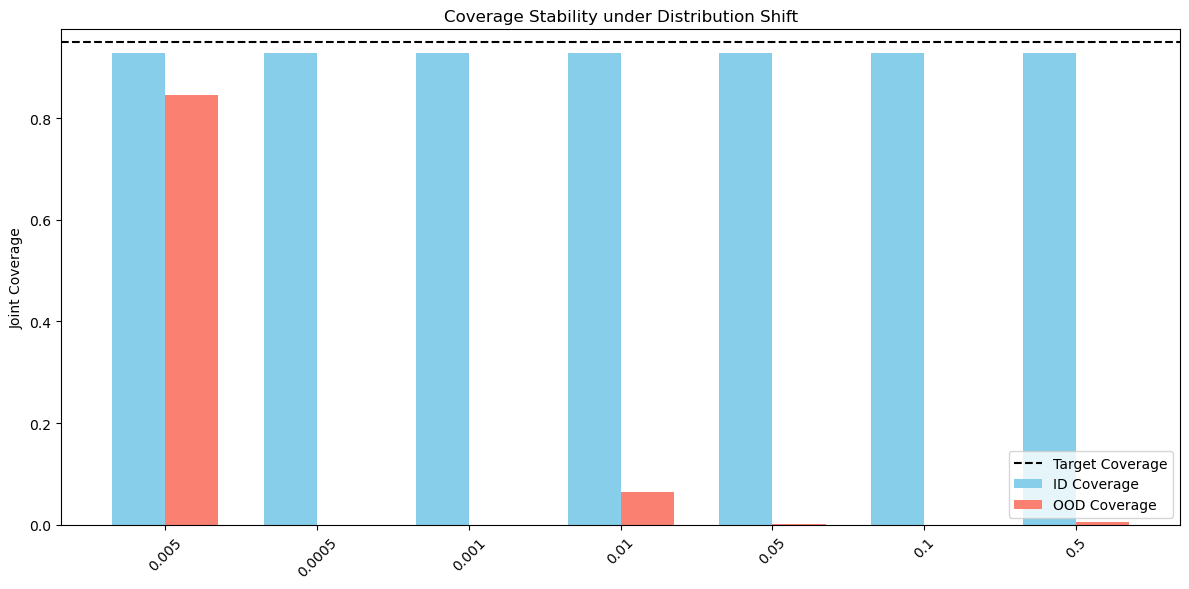

In [11]:
datatypes = [0.005, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.5]
alpha = 0.05
n_cal = 500

indices = np.arange(num_test)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:] # These are your "ID" test samples

# --- CALIBRATION ---
x_branch_cal = test_data['X_train'][cal_idx]
y_cal = test_data['Y_train'][cal_idx]
y_cal = y_cal.reshape(y_cal.shape[0], -1)

# Get model outputs for calibration
y_cal_pred, y_cal_std = cp.den_samples('fno', 'cuda', model_save_paths, x_branch_cal)

# Fit Conformal Regressor
cpregressor = cp.ConformalRegressor()
cpregressor.fit(y_cal, y_cal_pred, y_cal_std, alpha)

# --- STORAGE FOR SUMMARY PLOTS ---
metrics_summary = {
    'datatype': [],
    'id_coverage': [],
    'ood_coverage': [],
    'id_width': [],
    'ood_width': [],
    'correlation': []
}

# --- EVALUATION LOOP ---
# Create 2 rows of plots: Top for ROC, Bottom for Width/Coverage visualization
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
# Flatten axes for easier indexing if needed, or access by row/col
roc_axes = axes[0]
width_axes = axes[1]

print(f"{'Datatype':<15} | {'ID Cov':<10} | {'OOD Cov':<10} | {'ID Width':<10} | {'OOD Width':<10} | {'AUROC':<8}")
print("-" * 85)

for i, datatype in enumerate(datatypes):
    
    # 1. PREPARE DATA
    # Combine ID Test set + OOD Dataset [i]
    x_branch_ood = data_shifting_data[i]['X_train']
    y_ood_final = data_shifting_data[i]['Y_train']
    
    x_branch_final = np.concatenate((test_data['X_train'][test_idx], x_branch_ood), axis=0)
    y_test_final = np.concatenate((test_data['Y_train'][test_idx], y_ood_final), axis=0)
    y_test_final = y_test_final.reshape(y_test_final.shape[0], -1)
    
    # Model Predictions
    y_test_pred, y_test_std = cp.den_samples('fno', 'cuda', model_save_paths, x_branch_final)

    # 2. PREDICT INTERVALS
    lower_bound, upper_bound, is_ood = cpregressor.predict(y_test_pred, y_test_std)

    # 3. CALCULATE METRICS
    
    # A. Joint Coverage (Sample is covered only if ALL 100 dims are covered)
    # Shape: (n_samples, n_dims) -> (n_samples,)
    is_covered = np.all((y_test_final >= lower_bound) & (y_test_final <= upper_bound), axis=1)
    
    n_id = len(test_idx)
    cov_id = is_covered[:n_id].mean()
    cov_ood = is_covered[n_id:].mean()
    
    # B. Interval Width (Average across dimensions for each sample)
    # Shape: (n_samples,)
    avg_width_per_sample = np.mean(upper_bound - lower_bound, axis=1)
    width_id = avg_width_per_sample[:n_id].mean()
    width_ood = avg_width_per_sample[n_id:].mean()
    
    # C. Spearman Correlation (Error vs Uncertainty)
    # We usually check this on the ID data to see if model is "aware"
    abs_err_id = np.abs(y_test_final[:n_id] - y_test_pred[:n_id]).flatten()
    sigma_id = y_test_std[:n_id].flatten()
    corr, _ = spearmanr(abs_err_id, sigma_id)
    
    # D. OOD Detection (AUROC)
    # Create labels: 0 for ID, 1 for OOD
    labels = np.concatenate((np.zeros(n_id), np.ones(len(x_branch_ood))))
    
    # IMPORTANT: Use the raw uncertainty score (Max Sigma), NOT the boolean is_ood
    uncertainty_scores = np.max(y_test_std, axis=1)
    
    auroc = roc_auc_score(labels, uncertainty_scores)
    fpr, tpr, _ = roc_curve(labels, uncertainty_scores)

    # 4. STORE RESULTS
    metrics_summary['datatype'].append(datatype)
    metrics_summary['id_coverage'].append(cov_id)
    metrics_summary['ood_coverage'].append(cov_ood)
    metrics_summary['id_width'].append(width_id)
    metrics_summary['ood_width'].append(width_ood)
    metrics_summary['correlation'].append(corr)

    print(f"{datatype:<15} | {cov_id:.1%}      | {cov_ood:.1%}      | {width_id:.4f}     | {width_ood:.4f}      | {auroc:.4f}")

    # 5. PLOTTING
    
    # --- Top Row: ROC Curve ---
    ax_roc = roc_axes[i]
    ax_roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_roc.set_xlim([-0.01, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title(f'{datatype} (ROC)')
    if i == 0: ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # --- Bottom Row: Width Histograms ---
    # Visualizing how much wider the intervals get for OOD data
    ax_width = width_axes[i]
    ax_width.hist(avg_width_per_sample[:n_id], bins=20, alpha=0.5, label='ID', color='blue', density=True)
    ax_width.hist(avg_width_per_sample[n_id:], bins=20, alpha=0.5, label='OOD', color='red', density=True)
    ax_width.set_title(f'Interval Widths')
    ax_width.set_xlabel('Avg Width')
    if i == 0: ax_width.set_ylabel('Density')
    ax_width.legend()

plt.tight_layout()
plt.show()

# Summary Bar Chart for Coverage ---
fig2, ax2 = plt.subplots(figsize=(12, 6))
x = np.arange(len(datatypes))
width = 0.35

rects1 = ax2.bar(x - width/2, metrics_summary['id_coverage'], width, label='ID Coverage', color='skyblue')
rects2 = ax2.bar(x + width/2, metrics_summary['ood_coverage'], width, label='OOD Coverage', color='salmon')

ax2.axhline(y=1-alpha, color='black', linestyle='--', label='Target Coverage')
ax2.set_ylabel('Joint Coverage')
ax2.set_title('Coverage Stability under Distribution Shift')
ax2.set_xticks(x)
ax2.set_xticklabels(datatypes, rotation=45)
ax2.legend()
plt.tight_layout()
plt.show()